In [28]:
import pandas as pd
disease = pd.read_csv('all_gene_disease_associations.tsv', sep='\t')

In [29]:
raw_id_to_node_id_map = {}
id_index = 0
unique_gen_ids = disease['geneId'].unique()
total_genes = 0
total_diseases = 0
for gene_id in unique_gen_ids:
    raw_id_to_node_id_map[gene_id] = id_index
    id_index = id_index + 1
    total_genes = total_genes + 1
unique_disease_ids = disease['diseaseId'].unique()
for disease_id in unique_disease_ids:
    raw_id_to_node_id_map[disease_id] = id_index
    id_index = id_index + 1
    total_diseases = total_diseases + 1
print('total_genes', total_genes)
print('total_diseases', total_diseases)
print('id_index', id_index)

('total_genes', 17074)
('total_diseases', 20370)
('id_index', 37444)


In [30]:
disease.head()

,geneId,geneSymbol,diseaseId,diseaseName,score,NofPmids,NofSnps,source
0,1,A1BG,C0001418,Adenocarcinoma,0.002733,1,0,LHGDN
1,1,A1BG,C0002736,Amyotrophic Lateral Sclerosis,0.000275,1,0,BEFREE
2,1,A1BG,C0013080,Down Syndrome,0.000275,1,0,BEFREE
3,1,A1BG,C0017636,Glioblastoma,0.000275,1,0,BEFREE
4,1,A1BG,C3854222,Human immunodeficiency virus (HIV) II infectio...,0.000275,1,0,BEFREE


In [31]:
import snap
disease_graph = snap.TUNGraph.New()
# disease_graph = snap.TNGraph.New()
values = disease.values
N = values.shape[0]

for i in xrange(id_index):
    disease_graph.AddNode(i)
for i in xrange(N):
    row = values[i]
    src_internal_id = raw_id_to_node_id_map[row[0]]
    dst_internal_id = raw_id_to_node_id_map[row[2]]
#     if i > 10:
#         break
    disease_graph.AddEdge(src_internal_id, dst_internal_id)
print('disease_graph.GetEdges()',disease_graph.GetEdges())
print('disease_graph.GetNodes()',disease_graph.GetNodes())

('disease_graph.GetEdges()', 561119)
('disease_graph.GetNodes()', 37444)


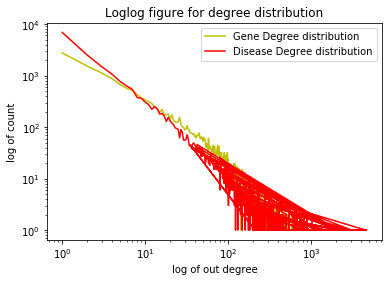

In [34]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  
gene_out_degree_to_count_map = {}
for node_id in xrange(total_genes):
    node = disease_graph.GetNI(node_id)
    if node.GetOutDeg() > 0:
        if node.GetOutDeg() in gene_out_degree_to_count_map:
            gene_out_degree_to_count_map[node.GetOutDeg()] = gene_out_degree_to_count_map[node.GetOutDeg()] + 1
        else:
            gene_out_degree_to_count_map[node.GetOutDeg()] = 1
keys = []
values = []
for key, value in gene_out_degree_to_count_map.items():
    keys.append(key)
    values.append(value)
gene_x = np.array(keys)
gene_y = np.array(values)
#
disease_out_degree_to_count_map = {}
for node_id in xrange(total_genes, id_index):
    node = disease_graph.GetNI(node_id)
#     print(node.GetOutDeg())
    if node.GetOutDeg() > 0:
        if node.GetOutDeg() in disease_out_degree_to_count_map:
            disease_out_degree_to_count_map[node.GetOutDeg()] = disease_out_degree_to_count_map[node.GetOutDeg()] + 1
        else:
            disease_out_degree_to_count_map[node.GetOutDeg()] = 1
keys = []
values = []
for key, value in disease_out_degree_to_count_map.items():
    keys.append(key)
    values.append(value)
disease_x = np.array(keys)
disease_y = np.array(values)
# print(keys)
# print(values)
plt.loglog(gene_x,gene_y, basex=10, basey=10, color = 'y', label = 'Gene Degree distribution')
plt.loglog(disease_x,disease_y, basex=10, basey=10, color = 'r', label = 'Disease Degree distribution')
plt.title('Loglog figure for degree distribution')
plt.xlabel('log of out degree')
plt.ylabel('log of count')
plt.legend()
plt.show()

In [45]:
derived_disease_graph = snap.TUNGraph.New()
for i in xrange(total_genes, id_index):
    derived_disease_graph.AddNode(i)
for i in xrange(total_genes, id_index):
    node_i = disease_graph.GetNI(i)
    relevant_set = set()
#     print(node_i, node_i.GetDeg())
    for nbr_i in xrange(node_i.GetDeg()):
        nbr_i_internal_id = node_i.GetNbrNId(nbr_i)
#         print('nbr_i_internal_id',nbr_i_internal_id)
        node_nbr = disease_graph.GetNI(nbr_i_internal_id)
#         print('node_nbr',node_nbr)
#             if node_nbr_i.IsNbrNId(j):
        for j in xrange(node_nbr.GetDeg()):
            node_nbr_i_j = node_nbr.GetNbrNId(j)
#             nbr_id = node_nbr_i_j.GetId()
            if i != node_nbr_i_j:
                derived_disease_graph.AddEdge(i, node_nbr_i_j)
        

In [48]:
print(derived_disease_graph.GetEdges())
derived_disease_graph.GetNodes()

12892536


20370

In [49]:
GraphClustCoeff = snap.GetClustCf (derived_disease_graph, 1)
print "Clustering coefficient: %f" % GraphClustCoeff

Clustering coefficient: 0.912721


In [111]:
import heapq

class MyHeap(object):
    def __init__(self, initial=None, key=lambda x:-x.GetDeg()):
        self.key = key
        if initial:
            self._data = [(key(item), item) for item in initial]
            heapq.heapify(self._data)
        else:
            self._data = []

    def push(self, item):
        heapq.heappush(self._data, (self.key(item), item))

    def pop(self):
        return heapq.heappop(self._data)[1]
# global_max = 0
global_max_list = [0]
def invoke_max_clique_heuristic(Graph, global_max_list):
    for NI in Graph.Nodes():
        if NI.GetDeg() >= global_max_list[0]:
            union = MyHeap()
            for Id in NI.GetOutEdges():
                node_for_id = Graph.GetNI(Id)
                union.push(node_for_id)
            max_clique_heuristic(Graph, union, 1, global_max_list)
def max_clique_heuristic(Graph, union, size, global_max_list):
#     print('1_union._data', len(union._data))
    if len(union._data) == 0:
        if size > global_max_list[0]:
            
            global_max_list[0] = size
#             print('2_global_max_list[0]',global_max_list[0], ' ,size: ', size)
        return
    max_deg_vertex = union.pop()
#     print('3_max_deg_vertex', max_deg_vertex.GetId())
    bigger_nodes = set()
    all_max_deg_vertex_nbrs = []
    for nbr_i in xrange(max_deg_vertex.GetDeg()):
        nbr_id = max_deg_vertex.GetNbrNId(nbr_i)
        if nbr_id == max_deg_vertex.GetId():
            continue
        nbr_node_i = Graph.GetNI(nbr_id)
#         all_max_deg_vertex_nbrs.append(nbr_node_i)
#         print('4_all_max_deg_vertex_nbrs add: ', nbr_node_i.GetId())
        if nbr_node_i.GetDeg() >= global_max_list[0]:
            bigger_nodes.add(nbr_node_i.GetId())
#             print('5_add_bigger_nodes',nbr_node_i.GetId())
    bigger_nbrs = filter(lambda x: x[1].GetId() in bigger_nodes,union._data)
    bigger_nbrs = map(lambda x: x[1],  bigger_nbrs)
#     print('6_bigger_nbrs size', len(bigger_nbrs))
    max_clique_heuristic(Graph,MyHeap(bigger_nbrs), size+1, global_max_list)


In [112]:
G1 = snap.TUNGraph.New()
G1.AddNode(1)
G1.AddNode(2)
G1.AddNode(3)
G1.AddNode(4)
G1.AddNode(5)
G1.AddNode(6)
G1.AddNode(7)
G1.AddNode(8)
G1.AddNode(9)
G1.AddEdge(1,2)
G1.AddEdge(1,3)
G1.AddEdge(2,3)
G1.AddEdge(3,4)
G1.AddEdge(4,5)
G1.AddEdge(5,6)
G1.AddEdge(5,7)
G1.AddEdge(5,8)
G1.AddEdge(6,7)
G1.AddEdge(6,8)
G1.AddEdge(7,8)
G1.AddEdge(5,9)
G1.AddEdge(6,9)
G1.AddEdge(7,9)
G1.AddEdge(8,9)
global_max_list = [0]
invoke_max_clique_heuristic(G1, global_max_list)
print(global_max_list[0])
print(G1.GetNI(5).GetDeg())

5
5


In [ ]:
derived_disease_graph
global_max_list = [0]
invoke_max_clique_heuristic(derived_disease_graph, global_max_list)
print(global_max_list[0])